<a href="https://colab.research.google.com/github/Brunoxue/hsi_examples/blob/main/unmixing_tite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperspectral Unmixing on Synthetic Target Implantation (TI) and Target Embeddedness (TE) Datasets with Python

In this demo project, we will demostrate various techniques for pixel-wised linear unmixing methods in hyperspectral images.

## 1. Download the Dataset from Github
Downloads the dataset by cloning the tite GitHub repository to the local environment. The dataset is stored in a folder named tite.

In [1]:
# Get dataset from Github repo
!git clone https://github.com/Brunoxue/tite.git

fatal: destination path 'tite' already exists and is not an empty directory.


## 2. Importing Required Libraries
The ```scipy.io.loadmat``` is used to load .mat (MATLAB) files. The ```numpy``` is a library for handling arrays and performing numerical operations. And the ```matplotlib``` is used for data visualization, specifically plotting images and graphs.

In [2]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

## 3. Loading the Dataset
First, we can load the variables from the tite_reflectance.mat file into the Python environment.

In [3]:
# Load the .mat file
data = loadmat('tite/tite_reflectance.mat')
hsi = data['TI2'].astype(np.double)
M = data['minerals'].astype(np.double)
label = data['minerals_label'].tolist()

BKG = loadmat('tite/cuprite_minerals_spectra_reflectance.mat')["background"]

M=np.hstack([M, BKG])

Next, we will display a selected band (100th band in this case) of the hyperspectral image and plot the reference spectra. The left panel contains the visualization of the reflectance intensity at the 100th spectral band, and the right panel shows the intensity curves of the materials (minerals and background) across all spectral bands.

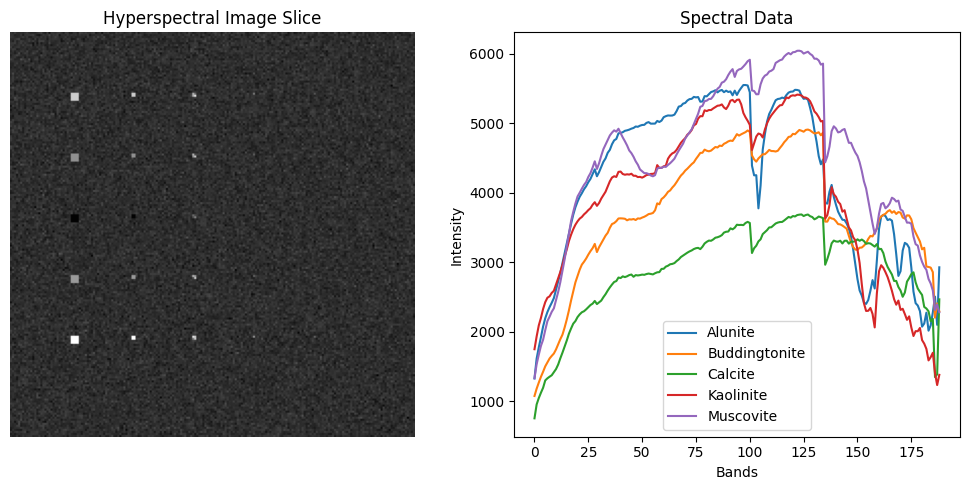

In [4]:
# Plot the hyperspectral image
fig, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
axs[0].imshow(hsi[:, :, 100], cmap='gray')
axs[0].axis('off')
axs[0].set_title('Hyperspectral Image Slice')

# Plot the spectrum
axs[1].plot(M[:,0:5])
axs[1].legend(['{}'.format(i[0][0]) for i in label])
axs[1].set_xlabel('Bands')
axs[1].set_ylabel('Intensity')
axs[1].set_title('Spectral Data')

plt.show()

## 4. Linear Unmixing using Least Squares (LS)
In this blocm, we apply the Least Squares (LS) method to estimate the abundance maps of the materials in the testing hyperspectral image. The output variable abundanceLS contains abundance maps for each of the 6 materials, and each panel in the figure shows the abundance spatial distribution of one material (and background).

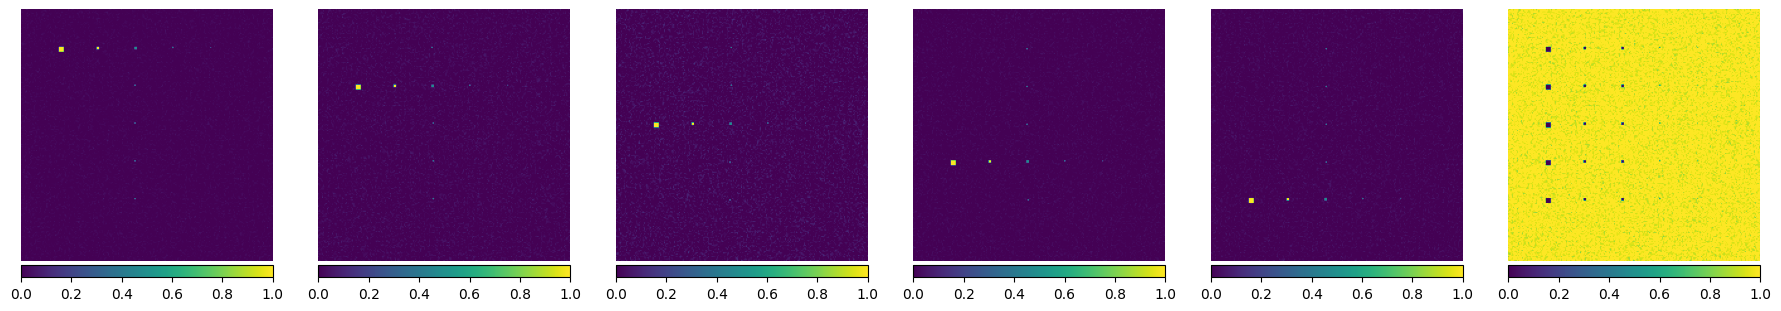

In [5]:
# Least Squares (LS)
def LS(HSI, M):
  x, y, L = HSI.shape
  N = x * y
  p = M.shape[1]

  r = HSI.reshape(N, L)
  M_inv = np.linalg.pinv(M.T @ M) @ M.T
  abundanceLS = M_inv @ r.T
  abundanceLS = abundanceLS.T.reshape(x, y, p)

  return abundanceLS

# Compute the abundance maps
abundanceLS = LS(hsi, M)

# Plot the abundance maps for LS
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(18, 4), subplot_kw={'xticks': [], 'yticks': []})
for idx in range(6):
    im = axs[idx].imshow(abundanceLS[:, :, idx], cmap='viridis', norm=Normalize(vmin=0, vmax=1))
    axs[idx].axis('off')
    fig.colorbar(im, ax=axs[idx], orientation='horizontal', pad=0.01)
plt.tight_layout()
plt.show()

## 5. Least Squares Orthogonal Subspace Projection (LSOSP)
The LSOSP method estimates the abundance of each material in the hyperspectral image while removing interference from other materials. This is done by projecting the data onto a subspace orthogonal to the spectra of all other undesired materials. The figure displays abundance maps for each of the 6 materials in separate subplots.

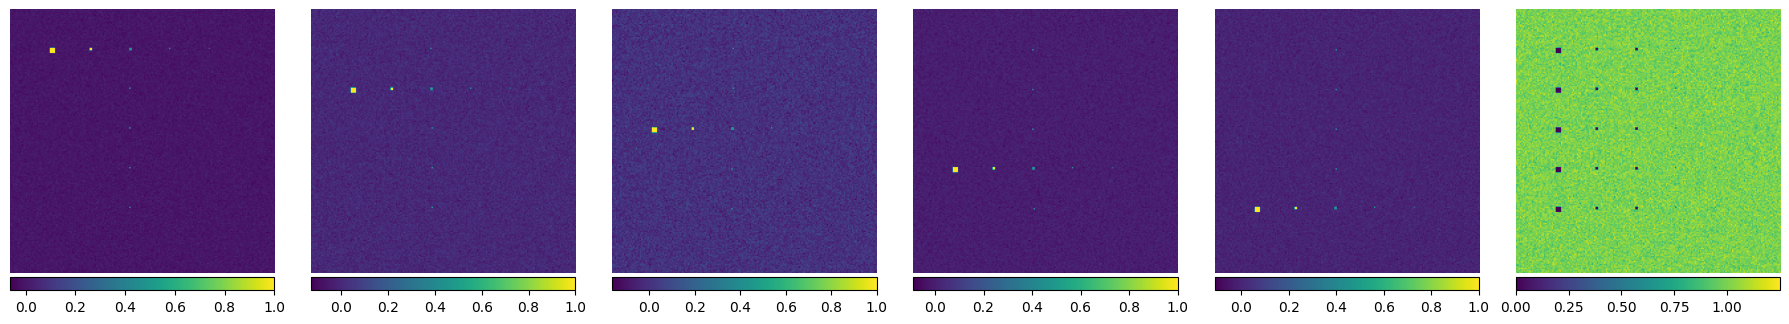

In [6]:
# Least Squares Orthogonal Subspace Projection (LSOSP)
def LSOSP(HSI, d, U):
    x, y, L = HSI.shape
    N = x * y
    r = HSI.reshape(N, L)

    # Calculate the projection matrix
    P_U_Per = np.eye(L) - U @ np.linalg.inv(U.T @ U) @ U.T

    # LSOSP formula
    lower = d.T @ P_U_Per @ d
    abundanceLSOSP = (d.T @ P_U_Per @ r.T) / lower
    abundanceLSOSP = abundanceLSOSP.reshape(x, y)

    return abundanceLSOSP

fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(18, 4), subplot_kw={'xticks': [], 'yticks': []})
for idx in range(6):
    d = M[:, idx]
    U = np.delete(M, idx, axis=1)
    abundanceLSOSP = LSOSP(hsi, d, U)
    im = axs[idx].imshow(abundanceLSOSP, cmap='viridis')
    axs[idx].axis('off')
    fig.colorbar(im, ax=axs[idx], orientation='horizontal', pad=0.01)

plt.tight_layout()
plt.show()

## 6. Linear Unmixing using Non-negative Constrained Least Squares (NCLS)
Next, we use the NCLS method, which constrains the abundance values to be non-negative.
Each subplot shows the abundance of materials in the scene as computed by the NCLS method.

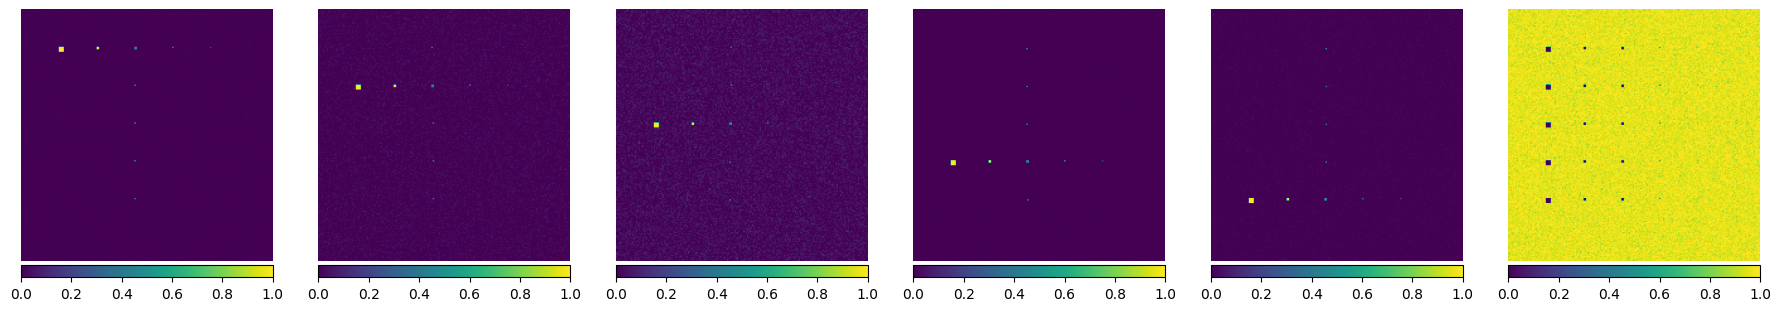

In [7]:
# Non-negative Constrained Least Squares (NCLS)
def NCLS(HSI, M):
    x, y, L = HSI.shape
    p = M.shape[1]

    N = x * y
    r = HSI.reshape(N, L).T

    from scipy.optimize import lsq_linear

    abundanceNCLS = np.zeros((N, p))
    for idx in range(N):
        result = lsq_linear(M, r[:, idx], bounds=(0, np.inf), method='bvls')
        abundanceNCLS[idx, :] = result.x

    abundanceNCLS = abundanceNCLS.reshape(x, y, p)

    return abundanceNCLS

# Compute the abundance maps
abundanceNCLS = NCLS(hsi, M)

# Plot the abundance maps for NCLS
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(18, 4), subplot_kw={'xticks': [], 'yticks': []})
for idx in range(6):
    im = axs[idx].imshow(abundanceNCLS[:, :, idx], cmap='viridis', norm=Normalize(vmin=0, vmax=1))
    axs[idx].axis('off')
    fig.colorbar(im, ax=axs[idx], orientation='horizontal', pad=0.01)
plt.tight_layout()
plt.show()

## 7. Linear Unmixing using Fully Constrained Least Squares (FCLS)
The FCLS method follows two important constraints on the abundance estimates, which are non-negativity(same as the NCLS), and the sum-to-one (the abundance values across all materials must sum to one for each pixel, ensuring that the materials completely describe the pixel).

Each subplot represents the estimated abundance of a specific material, ensuring that the abundance follows non-negative and sum-to-one constraints.

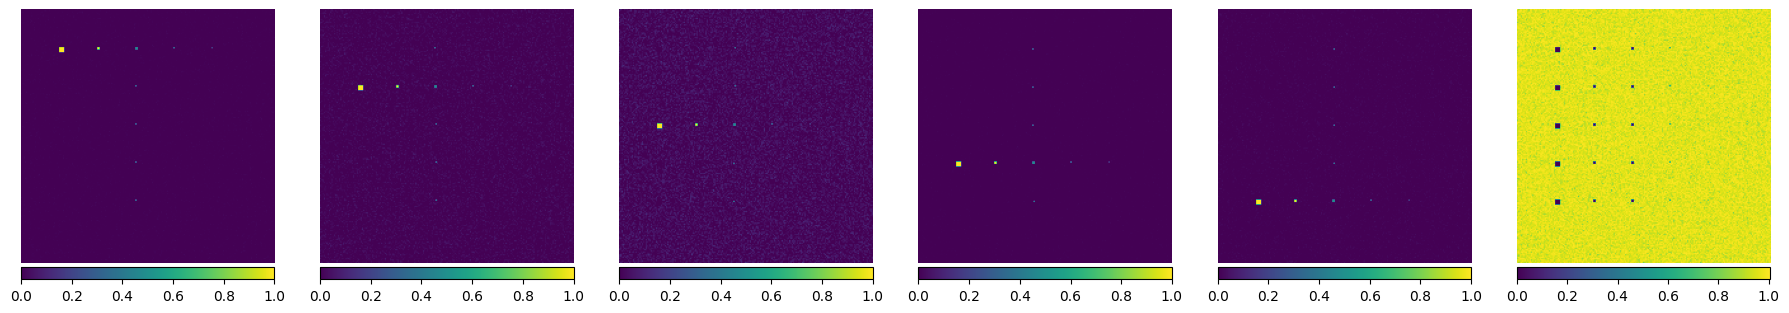

In [8]:
# Fully Constrained Least Squares (FCLS)
def FCLS(HSI, M):
    x, y, L = HSI.shape
    p = M.shape[1]
    N = x * y
    r = HSI.reshape(N, L).T

    M = np.vstack([M, np.ones((1, p))])
    r = np.vstack([r, np.ones((1, N))])

    from scipy.optimize import lsq_linear

    abundanceFCLS = np.zeros((N, p))
    for idx in range(N):
        result = lsq_linear(M, r[:, idx], bounds=(0, np.inf), method='bvls')
        abundanceFCLS[idx, :] = result.x

    abundanceFCLS = abundanceFCLS.reshape(x, y, p)

    return abundanceFCLS

# Compute the abundance maps
abundanceFCLS = FCLS(hsi, M)

# Plot the abundance maps for FCLS
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(18, 4), subplot_kw={'xticks': [], 'yticks': []})
for idx in range(6):
    im = axs[idx].imshow(abundanceFCLS[:, :, idx], cmap='viridis')
    axs[idx].axis('off')
    fig.colorbar(im, ax=axs[idx], orientation='horizontal', pad=0.01)
plt.tight_layout()
plt.show()